In [2]:
from __future__ import division, print_function, unicode_literals
#!pip install imblearn
#!pip install mlxtend 
#!pip install xgboost
#!python -m pip install featuretools
import numpy as np
import pandas as pd
import xgboost
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns

from sklearn import ensemble, linear_model, preprocessing, model_selection
from sklearn.metrics import roc_curve, auc, f1_score, mean_squared_error, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from imblearn import over_sampling as os
from imblearn import under_sampling as us
from imblearn import pipeline as pl
from collections import Counter
from scipy import stats
from xgboost import XGBClassifier
from IPython.display import Image
from matplotlib.colors import ListedColormap
sns.set(color_codes = True)
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Data Preparation

In [3]:
Trainraw = pd.read_csv("HW4 - training data.csv", sep=";")
Testraw = pd.read_csv("HW4 - test data.csv", sep=";")

In [36]:
Counter(Trainraw['adopter'])

Counter({0: 85142, 1: 1540})

In [4]:
print(Trainraw.shape)
Trainraw.head()

(86682, 27)


,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter,user_id
0,24.0,0.0,20.0,26.333333,0.777778,6.0,0.0,37804.0,4.0,20.0,...,54.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0,0,10.0
1,29.0,1.0,12.0,26.900000,0.818182,6.0,1.0,15955.0,19.0,4.0,...,802.0,0.0,0.0,0.0,1.0,80.0,0.0,0.0,0,58.0
2,22.0,0.0,4.0,21.000000,1.000000,2.0,0.0,31441.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0,72.0
3,27.0,0.0,1.0,29.000000,1.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,59.0,0.0,0.0,0,121.0
4,22.0,1.0,4.0,21.250000,0.750000,1.0,0.0,774.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0,0,137.0


In [5]:
print(Testraw.shape)
Testraw.head()

(86681, 26)


,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,user_id
0,29.0,1.0,36.0,23.785714,0.764706,9.0,0.0,9246.0,2.0,132.0,...,0.0,152.0,0.0,0.0,0.0,0.0,81.0,1.0,0.0,5.0
1,22.0,1.0,2.0,22.500000,0.500000,1.0,0.0,7568.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0,41.0
2,22.0,0.0,9.0,27.375000,0.666667,1.0,0.0,16465.0,103.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.0,1.0,0.0,77.0
3,18.0,1.0,2.0,18.000000,1.000000,1.0,0.0,60876.0,14.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,57.0,1.0,0.0,99.0
4,20.0,0.0,3.0,25.000000,1.000000,1.0,0.0,1189.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,106.0


In [6]:
print(len(Trainraw.user_id.unique()))
print(len(Testraw.user_id.unique()))

86682
86681


In [7]:
Counter(Trainraw['adopter'])

Counter({0: 85142, 1: 1540})

In [8]:
Trainraw.iloc[:,0:15].describe()

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,playlists,shouts,delta_friend_cnt,delta_avg_friend_age,delta_avg_friend_male
count,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000
mean,23.993067,0.622217,18.988521,24.068308,0.617246,4.040147,0.434935,18193.939849,89.276032,6.095775,0.565135,29.870861,0.870100,0.274033,-0.000367
std,6.388225,0.484836,57.934430,5.127068,0.318587,5.843532,1.853233,28684.095167,320.788514,157.159803,1.467784,154.738076,6.492898,0.766965,0.051992
min,8.000000,0.000000,1.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-212.000000,-50.000000,-1.000000
25%,20.000000,0.000000,3.000000,20.750000,0.428571,1.000000,0.000000,1347.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,23.000000,1.000000,7.000000,23.000000,0.666667,2.000000,0.000000,7781.000000,15.000000,0.000000,0.000000,4.000000,0.000000,0.246544,0.000000
75%,26.000000,1.000000,18.000000,26.157895,0.900000,4.000000,0.000000,23583.000000,74.000000,0.000000,1.000000,15.000000,0.000000,0.454545,0.000000
max,79.000000,1.000000,6437.000000,77.000000,1.000000,122.000000,225.000000,922370.000000,56389.000000,25815.000000,167.000000,15004.000000,396.000000,53.000000,1.000000


In [9]:
Trainraw.iloc[:,15:27].describe()

,delta_friend_country_cnt,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter,user_id
count,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,86682.000000,8.668200e+04
mean,0.105847,-0.021054,942.677188,4.716723,0.279158,0.002757,0.954500,44.350061,0.352045,0.000242,0.017766,8.547774e+05
std,0.843507,0.534960,2856.036359,155.648950,43.782235,0.177153,19.209259,19.707058,0.477611,0.034803,0.132101,4.938304e+05
min,-29.000000,-18.000000,-135022.000000,-951.000000,-264.000000,-5.000000,-2752.000000,0.000000,0.000000,-1.000000,0.000000,1.000000e+01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000000,4.279675e+05
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,0.000000,0.000000,0.000000,8.520060e+05
75%,0.000000,0.000000,913.000000,0.000000,0.000000,0.000000,0.000000,59.000000,1.000000,0.000000,0.000000,1.282592e+06
max,41.000000,19.000000,217876.000000,44900.000000,12702.000000,20.000000,2036.000000,112.000000,1.000000,1.000000,1.000000,1.708942e+06


In [10]:
# defining our target
target = Trainraw[["adopter"]]

# defining our features 
features = Trainraw.drop(["adopter", "user_id"], axis=1)
testfeat = Testraw.drop(["user_id"], axis=1)
fullfeat = features
fullfeat = fullfeat.append(testfeat)

# Create X and y arrays
X = np.asmatrix(features.values)
y = np.asmatrix(target.values)

In [11]:
fullfeat

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_friend_country_cnt,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country
0,24.0,0.0,20.0,26.333333,0.777778,6.0,0.0,37804.0,4.0,20.0,...,0.0,0.0,54.0,0.0,0.0,0.0,0.0,79.0,0.0,0.0
1,29.0,1.0,12.0,26.900000,0.818182,6.0,1.0,15955.0,19.0,4.0,...,0.0,0.0,802.0,0.0,0.0,0.0,1.0,80.0,0.0,0.0
2,22.0,0.0,4.0,21.000000,1.000000,2.0,0.0,31441.0,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0
3,27.0,0.0,1.0,29.000000,1.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.0,0.0,0.0
4,22.0,1.0,4.0,21.250000,0.750000,1.0,0.0,774.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86676,18.0,1.0,1.0,18.000000,1.000000,1.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0
86677,23.0,0.0,10.0,30.777778,1.000000,6.0,1.0,11973.0,2.0,5.0,...,0.0,0.0,1048.0,2.0,0.0,0.0,0.0,41.0,0.0,0.0
86678,21.0,0.0,6.0,20.500000,1.000000,6.0,0.0,27545.0,0.0,0.0,...,1.0,0.0,349.0,0.0,0.0,0.0,0.0,23.0,1.0,0.0
86679,21.0,1.0,17.0,21.500000,0.714286,3.0,0.0,28694.0,32.0,0.0,...,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,0.0,0.0


In [12]:
userid = Trainraw['user_id']
userid = userid.append(Testraw['user_id'])
print(len(userid))

173363


In [13]:
# count examples in each class
counter = Counter(target['adopter'])
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 55.287


In [58]:
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
features_std = pd.DataFrame(sc.fit_transform(features),columns = features.columns)

## Interaction Terms (Categorical Variables)

In [15]:
fullfeat.columns

Index(['age', 'male', 'friend_cnt', 'avg_friend_age', 'avg_friend_male',
       'friend_country_cnt', 'subscriber_friend_cnt', 'songsListened',
       'lovedTracks', 'posts', 'playlists', 'shouts', 'delta_friend_cnt',
       'delta_avg_friend_age', 'delta_avg_friend_male',
       'delta_friend_country_cnt', 'delta_subscriber_friend_cnt',
       'delta_songsListened', 'delta_lovedTracks', 'delta_posts',
       'delta_playlists', 'delta_shouts', 'tenure', 'good_country',
       'delta_good_country'],
      dtype='object')

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)#, interaction_only=True)
to_cross = ['age', 'male', 'friend_cnt', 'avg_friend_age', 'avg_friend_male',
       'friend_country_cnt', 'subscriber_friend_cnt', 'songsListened',
       'lovedTracks', 'posts', 'playlists', 'shouts', 'delta_friend_cnt',
       'delta_avg_friend_age', 'delta_avg_friend_male',
       'delta_friend_country_cnt', 'delta_subscriber_friend_cnt',
       'delta_songsListened', 'delta_lovedTracks', 'delta_posts',
       'delta_playlists', 'delta_shouts', 'tenure', 'good_country',
       'delta_good_country']
crossed_feats = poly.fit_transform(fullfeat[to_cross].values)


#Convert to Pandas DataFrame and merge to original dataset
crossed_feats = pd.DataFrame(crossed_feats)
crossed_feats.columns= poly.get_feature_names(fullfeat[to_cross].columns)

In [17]:
crossed_feats

,1,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta_shouts^2,delta_shouts tenure,delta_shouts good_country,delta_shouts delta_good_country,tenure^2,tenure good_country,tenure delta_good_country,good_country^2,good_country delta_good_country,delta_good_country^2
0,1.0,24.0,0.0,20.0,26.333333,0.777778,6.0,0.0,37804.0,4.0,...,0.0,0.0,0.0,0.0,6241.0,0.0,0.0,0.0,0.0,0.0
1,1.0,29.0,1.0,12.0,26.900000,0.818182,6.0,1.0,15955.0,19.0,...,1.0,80.0,0.0,0.0,6400.0,0.0,0.0,0.0,0.0,0.0
2,1.0,22.0,0.0,4.0,21.000000,1.000000,2.0,0.0,31441.0,7.0,...,0.0,0.0,0.0,0.0,2809.0,0.0,0.0,0.0,0.0,0.0
3,1.0,27.0,0.0,1.0,29.000000,1.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3481.0,0.0,0.0,0.0,0.0,0.0
4,1.0,22.0,1.0,4.0,21.250000,0.750000,1.0,0.0,774.0,0.0,...,0.0,0.0,0.0,0.0,3600.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173358,1.0,18.0,1.0,1.0,18.000000,1.000000,1.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,529.0,0.0,0.0,0.0,0.0,0.0
173359,1.0,23.0,0.0,10.0,30.777778,1.000000,6.0,1.0,11973.0,2.0,...,0.0,0.0,0.0,0.0,1681.0,0.0,0.0,0.0,0.0,0.0
173360,1.0,21.0,0.0,6.0,20.500000,1.000000,6.0,0.0,27545.0,0.0,...,0.0,0.0,0.0,0.0,529.0,23.0,0.0,1.0,0.0,0.0
173361,1.0,21.0,1.0,17.0,21.500000,0.714286,3.0,0.0,28694.0,32.0,...,1.0,29.0,0.0,0.0,841.0,0.0,0.0,0.0,0.0,0.0


In [18]:
crossed_feats.columns

Index(['1', 'age', 'male', 'friend_cnt', 'avg_friend_age', 'avg_friend_male',
       'friend_country_cnt', 'subscriber_friend_cnt', 'songsListened',
       'lovedTracks',
       ...
       'delta_shouts^2', 'delta_shouts tenure', 'delta_shouts good_country',
       'delta_shouts delta_good_country', 'tenure^2', 'tenure good_country',
       'tenure delta_good_country', 'good_country^2',
       'good_country delta_good_country', 'delta_good_country^2'],
      dtype='object', length=351)

In [19]:
crossed_feats = crossed_feats.loc[:,~crossed_feats.columns.duplicated()]
crossed_feats = crossed_feats.drop(["1"], axis=1)

In [20]:
print("The dataset has {} rows and {} columns - after adding interaction terms.".format(*crossed_feats.shape))

The dataset has 173363 rows and 350 columns - after adding interaction terms.


# PARAMETER Standardization

In [21]:
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
features_std = pd.DataFrame(sc.fit_transform(crossed_feats),columns = crossed_feats.columns)

In [22]:
features_std

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_shouts^2,delta_shouts tenure,delta_shouts good_country,delta_shouts delta_good_country,tenure^2,tenure good_country,tenure delta_good_country,good_country^2,good_country delta_good_country,delta_good_country^2
0,-0.000445,-1.287319,0.012652,0.443622,0.503366,0.330579,-0.229176,0.680459,-0.247332,0.113718,...,-0.011865,-0.052365,-0.019821,-0.00084,2.137207,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
1,0.781956,0.776808,-0.107739,0.554396,0.630233,0.330579,0.294132,-0.075059,-0.204646,-0.014491,...,-0.011839,0.092233,-0.019821,-0.00084,2.224523,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
2,-0.313405,-1.287319,-0.228131,-0.598950,1.201136,-0.349876,-0.229176,0.460433,-0.238795,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,0.252495,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
3,0.468996,-1.287319,-0.273277,0.964909,1.201136,-0.519990,-0.229176,-0.626769,-0.258715,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,0.621530,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
4,-0.313405,0.776808,-0.228131,-0.550079,0.416145,-0.519990,-0.229176,-0.600005,-0.258715,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,0.686880,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173358,-0.939326,0.776808,-0.273277,-1.185397,1.201136,-0.519990,-0.229176,-0.626769,-0.244486,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,-0.999585,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
173359,-0.156925,-1.287319,-0.137837,1.312433,1.201136,0.330579,0.294132,-0.212753,-0.253023,-0.006478,...,-0.011865,-0.052365,-0.019821,-0.00084,-0.366955,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
173360,-0.469886,-1.287319,-0.198033,-0.696691,1.201136,0.330579,-0.229176,0.325712,-0.258715,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,-0.999585,0.231043,-0.007174,1.354245,-0.027076,-0.034825
173361,-0.469886,0.776808,-0.032495,-0.501209,0.304003,-0.179763,-0.229176,0.365444,-0.167652,-0.046544,...,-0.011839,0.000051,-0.019821,-0.00084,-0.828248,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825


In [23]:
trainfinal = features_std.iloc[:86682,:]
testfinal = features_std.iloc[86682:,:]

In [24]:
trainfinal["adopter"] = target

In [25]:
trainfinal

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_shouts tenure,delta_shouts good_country,delta_shouts delta_good_country,tenure^2,tenure good_country,tenure delta_good_country,good_country^2,good_country delta_good_country,delta_good_country^2,adopter
0,-0.000445,-1.287319,0.012652,0.443622,0.503366,0.330579,-0.229176,0.680459,-0.247332,0.113718,...,-0.052365,-0.019821,-0.00084,2.137207,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0
1,0.781956,0.776808,-0.107739,0.554396,0.630233,0.330579,0.294132,-0.075059,-0.204646,-0.014491,...,0.092233,-0.019821,-0.00084,2.224523,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0
2,-0.313405,-1.287319,-0.228131,-0.598950,1.201136,-0.349876,-0.229176,0.460433,-0.238795,-0.046544,...,-0.052365,-0.019821,-0.00084,0.252495,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0
3,0.468996,-1.287319,-0.273277,0.964909,1.201136,-0.519990,-0.229176,-0.626769,-0.258715,-0.046544,...,-0.052365,-0.019821,-0.00084,0.621530,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0
4,-0.313405,0.776808,-0.228131,-0.550079,0.416145,-0.519990,-0.229176,-0.600005,-0.258715,-0.046544,...,-0.052365,-0.019821,-0.00084,0.686880,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86677,-0.626366,-1.287319,-0.258229,-0.501209,1.201136,-0.519990,-0.229176,0.093272,0.031547,-0.046544,...,-0.052365,-0.019821,-0.00084,-0.578381,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0
86678,-0.626366,-1.287319,-0.047544,-0.712981,-0.972686,-0.349876,-0.229176,-0.343704,-0.258715,-0.046544,...,-0.052365,-0.019821,-0.00084,0.028439,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0
86679,-0.313405,-1.287319,0.042750,-0.403468,-1.589945,-0.009649,-0.229176,1.361218,0.279123,-0.046544,...,-0.052365,-0.019821,-0.00084,0.252495,1.384962,-0.007174,1.354245,-0.027076,-0.034825,0
86680,-0.156925,-1.287319,0.072848,-0.189368,-0.027546,0.500693,-0.229176,-0.548136,-0.011138,0.442253,...,-0.130087,-0.019821,-0.00084,-0.274697,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825,0


In [26]:
testfinal

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_shouts^2,delta_shouts tenure,delta_shouts good_country,delta_shouts delta_good_country,tenure^2,tenure good_country,tenure delta_good_country,good_country^2,good_country delta_good_country,delta_good_country^2
86682,0.781956,0.776808,0.253434,-0.054392,0.462321,0.840920,-0.229176,-0.307051,-0.253023,1.011181,...,-0.011865,-0.052365,-0.019821,-0.00084,2.312937,2.461954,-0.007174,1.354245,-0.027076,-0.034825
86683,-0.313405,0.776808,-0.258229,-0.305726,-0.368847,-0.519990,-0.229176,-0.365074,-0.258715,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,2.137207,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
86684,-0.313405,-1.287319,-0.152886,0.647250,0.154481,-0.519990,-0.229176,-0.057424,0.034393,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,0.820874,1.731138,-0.007174,1.354245,-0.027076,-0.034825
86685,-0.939326,0.776808,-0.258229,-1.185397,1.201136,-0.519990,-0.229176,1.478269,-0.218875,-0.030518,...,-0.011865,-0.052365,-0.019821,-0.00084,0.494125,1.538818,-0.007174,1.354245,-0.027076,-0.034825
86686,-0.626366,-1.287319,-0.243180,0.182979,1.201136,-0.519990,-0.229176,-0.585654,-0.221721,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,0.028439,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173358,-0.939326,0.776808,-0.273277,-1.185397,1.201136,-0.519990,-0.229176,-0.626769,-0.244486,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,-0.999585,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
173359,-0.156925,-1.287319,-0.137837,1.312433,1.201136,0.330579,0.294132,-0.212753,-0.253023,-0.006478,...,-0.011865,-0.052365,-0.019821,-0.00084,-0.366955,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825
173360,-0.469886,-1.287319,-0.198033,-0.696691,1.201136,0.330579,-0.229176,0.325712,-0.258715,-0.046544,...,-0.011865,-0.052365,-0.019821,-0.00084,-0.999585,0.231043,-0.007174,1.354245,-0.027076,-0.034825
173361,-0.469886,0.776808,-0.032495,-0.501209,0.304003,-0.179763,-0.229176,0.365444,-0.167652,-0.046544,...,-0.011839,0.000051,-0.019821,-0.00084,-0.828248,-0.653628,-0.007174,-0.738419,-0.027076,-0.034825


### 2.2 Feature Selection

#### 2.3.1 The first thing we try is selecting features based on correlation.
We keep the feature with absolute correlation values larger than 1.

In [27]:
corrmatrix = trainfinal.corr()

In [28]:
corrmatrix_y = corrmatrix["adopter"].sort_values(ascending=False)
print("max correlation: " + str(max(corrmatrix_y[corrmatrix_y < 1])) + 
      " , min correlation: " + str(min(corrmatrix_y)))

max correlation: 0.07883093059079381 , min correlation: -0.024346527185297055


In [29]:
badvars = list(corrmatrix_y[abs(corrmatrix_y) <= 0.05].index.values)

In [30]:
# We decided to only keep features that have absolute correlation with target variable larger than 0.001
cortrim = trainfinal.drop(badvars, axis=1)
print(cortrim.shape)
varlen = len(cortrim.columns)

(86682, 31)


#### 2.3.2 The second thing we try is to use a stepwise auto-selecting method. The package is called "mlxtend". You need to install both "mlxtend" and "joblib" in Anaconda in order to run it.

In [14]:
#####################################    Set inner and outer cv   ############################################
param_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

## XGBOOST Sequential Feature Slection

In [ ]:
# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
gb = XGBClassifier(booster='gbtree', verbosity=2, nthread=-1, n_jobs=-1, random_state=42,learning_rate=0.5)

sfs1 = SFS(gb,
           # Change the features number accordingly.
           k_features=varlen,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='f1',
           cv=inner_cv,
           n_jobs=-1)

sfs1 = sfs1.fit(cortrim, target)
pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:   50.7s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  1.1min finished

[2020-04-26 21:00:11] Features: 1/31 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   30.7s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   39.7s finished

[2020-04-26 21:00:51] Features: 2/31 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  29 | elapsed:   33.0s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  29 out of  29 | elapsed:   42.4s finished

[2020-04-26 21:01:33] Features: 3/31 -- score: 1.0[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  28 | elapsed:   35.7s remaining:   14.2s
[P

In [39]:
output = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
features_fw = output[output.avg_score==max(output.avg_score)].feature_names
features_fw_gb = list(list(features_fw)[0])
features_fw_gb = features[features_fw_gb]#change feature to features_cor to use correlation results
print('Chosen features for Extreme Gradient Boosting:',features_fw_gb.columns)
print('Extreme Gradient Boosting after (step 2) selected features f1: ',max(output.avg_score))

Chosen features for Extreme Gradient Boosting: Index(['age', 'male', 'friend_cnt', 'avg_friend_age', 'subscriber_friend_cnt',
       'songsListened', 'lovedTracks', 'playlists', 'shouts',
       'delta_avg_friend_male', 'delta_songsListened', 'delta_lovedTracks',
       'delta_posts', 'delta_playlists', 'good_country', 'delta_good_country'],
      dtype='object')
Extreme Gradient Boosting after (step 2) selected features f1:  0.08981016151909099


In [41]:
features_fw_gb = features[['age', 'male', 'friend_cnt', 'avg_friend_age', 'subscriber_friend_cnt',
       'songsListened', 'lovedTracks', 'playlists', 'shouts',
       'delta_avg_friend_male', 'delta_songsListened', 'delta_lovedTracks',
       'delta_posts', 'delta_playlists', 'good_country', 'delta_good_country']]
#change feature to features_cor to use correlation results

In [40]:
features_fw_gb

,age,male,friend_cnt,avg_friend_age,subscriber_friend_cnt,songsListened,lovedTracks,playlists,shouts,delta_avg_friend_male,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,good_country,delta_good_country
0,24.0,0.0,20.0,26.333333,0.0,37804.0,4.0,1.0,47.0,0.0,54.0,0.0,0.0,0.0,0.0,0.0
1,29.0,1.0,12.0,26.900000,1.0,15955.0,19.0,0.0,8.0,0.0,802.0,0.0,0.0,0.0,0.0,0.0
2,22.0,0.0,4.0,21.000000,0.0,31441.0,7.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.0,0.0,1.0,29.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,22.0,1.0,4.0,21.250000,0.0,774.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86677,20.0,0.0,2.0,21.500000,0.0,20823.0,102.0,0.0,6.0,0.0,369.0,1.0,0.0,0.0,0.0,0.0
86678,20.0,0.0,16.0,20.416667,0.0,8186.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86679,22.0,0.0,22.0,22.000000,0.0,57491.0,189.0,0.0,9.0,0.0,5083.0,0.0,0.0,0.0,1.0,0.0
86680,23.0,0.0,24.0,23.095238,0.0,2274.0,87.0,0.0,26.0,0.0,166.0,27.0,7.0,0.0,0.0,0.0


## 2. Modelling

### 2.1. Define feature set and target variable & Choosing Sampling technique

#### 2.1.1 SMOTE

In [43]:
# Apply the random over-sampling
pipeline = pl.make_pipeline(os.SMOTE(),linear_model.LogisticRegression(
    penalty='l2',
    C=1,
    solver='liblinear',
    random_state=42)
    )



n_folds = 5
store_Roc_Auc = np.zeros(n_folds)

# Split to test and train set
results=[]
skf = StratifiedKFold(n_splits=n_folds)
aaa = 0
for train_index, test_index in skf.split(X,y):
    probas = pipeline.fit(X[train_index], y[train_index]).predict_proba(X[test_index])
    preds = probas[:, 1]
    fpr, tpr, threshold = roc_curve(y[test_index], preds)

    print("Show fpr  ----------------------------")
    print(fpr)
    print("Show tpr -----------------------------")
    print(tpr)


    roc_auc = auc(fpr, tpr)

    results.append(roc_auc)
    print("Show roc_auc   -----------------------")
    print(roc_auc)
    
    store_Roc_Auc[aaa] = roc_auc
    print("Show store_Roc_Auc   -----------------------")
    print(store_Roc_Auc)
    aaa = aaa+1

roc_auc = auc(fpr, tpr)

Show fpr  ----------------------------
[0.00000000e+00 1.17446709e-04 6.45956897e-04 6.45956897e-04
 9.98297023e-04 9.98297023e-04 1.40936050e-03 1.40936050e-03
 1.58553057e-03 1.58553057e-03 3.28850784e-03 3.28850784e-03
 3.69957132e-03 3.69957132e-03 4.11063480e-03 4.11063480e-03
 5.69616536e-03 5.69616536e-03 6.51829232e-03 6.51829232e-03
 6.87063245e-03 6.87063245e-03 7.63403606e-03 7.63403606e-03
 7.75148276e-03 7.75148276e-03 8.39743966e-03 8.39743966e-03
 9.51318339e-03 9.51318339e-03 9.86552352e-03 9.86552352e-03
 9.98297023e-03 9.98297023e-03 1.01591403e-02 1.01591403e-02
 1.05114804e-02 1.05114804e-02 1.10399906e-02 1.10399906e-02
 1.14510541e-02 1.14510541e-02 1.19795643e-02 1.19795643e-02
 1.22731810e-02 1.22731810e-02 1.25667978e-02 1.25667978e-02
 1.29191379e-02 1.29191379e-02 1.43284984e-02 1.43284984e-02
 1.65012626e-02 1.65012626e-02 1.66187093e-02 1.66187093e-02
 1.76170063e-02 1.76170063e-02 1.79693464e-02 1.79693464e-02
 1.89676434e-02 1.89676434e-02 1.90263668e-02 

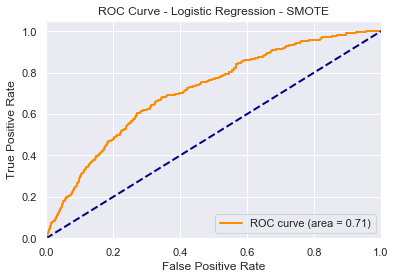

In [32]:
#Let's see the results of SMOTE
# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression - SMOTE')
plt.legend(loc="lower right")
plt.show()

#### 2.1.2 RUS

In [33]:
# Apply the random under-sampling
pipeline = pl.make_pipeline(us.RandomUnderSampler(),linear_model.LogisticRegression(
    penalty='l2',
    C=1,
    solver='liblinear',
    random_state=42)
    )


n_folds = 5
store_Roc_Auc = np.zeros(n_folds)

# Split to test and train set
results=[]
skf = StratifiedKFold(n_splits=n_folds)
aaa = 0
for train_index, test_index in skf.split(X,y):
    probas = pipeline.fit(X[train_index], y[train_index]).predict_proba(X[test_index])
    preds = probas[:, 1]
    fpr, tpr, threshold = roc_curve(y[test_index], preds)

    print("Show fpr  ----------------------------")
    print(fpr)
    print("Show tpr -----------------------------")
    print(tpr)


    roc_auc = auc(fpr, tpr)

    results.append(roc_auc)
    print("Show roc_auc   -----------------------")
    print(roc_auc)
    
    store_Roc_Auc[aaa] = roc_auc
    print("Show store_Roc_Auc   -----------------------")
    print(store_Roc_Auc)
    aaa = aaa+1

roc_auc = auc(fpr, tpr)

Show fpr  ----------------------------
[0.00000000e+00 5.87233543e-05 7.04680251e-04 7.04680251e-04
 1.40936050e-03 1.40936050e-03 1.99659405e-03 1.99659405e-03
 2.46638088e-03 2.46638088e-03 3.58212461e-03 3.58212461e-03
 4.34552822e-03 4.34552822e-03 4.46297493e-03 4.46297493e-03
 4.93276176e-03 4.93276176e-03 6.28339891e-03 6.28339891e-03
 8.33871631e-03 8.33871631e-03 8.63233308e-03 8.63233308e-03
 8.98467320e-03 8.98467320e-03 9.39573668e-03 9.39573668e-03
 9.68935346e-03 9.68935346e-03 1.02765870e-02 1.02765870e-02
 1.05702038e-02 1.05702038e-02 1.07463738e-02 1.07463738e-02
 1.20382876e-02 1.20382876e-02 1.24493511e-02 1.24493511e-02
 1.25667978e-02 1.25667978e-02 1.26255212e-02 1.26255212e-02
 1.85565800e-02 1.85565800e-02 1.88501967e-02 1.88501967e-02
 1.96136003e-02 1.96136003e-02 2.09055141e-02 2.09055141e-02
 2.20799812e-02 2.20799812e-02 2.26672148e-02 2.26672148e-02
 2.31370016e-02 2.31370016e-02 2.38416818e-02 2.38416818e-02
 2.44289154e-02 2.44289154e-02 2.48399789e-02 

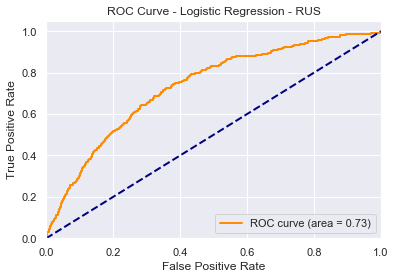

In [34]:
#Let's see the results of RUS
# Plot of a ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression - RUS')
plt.legend(loc="lower right")
plt.show()

In [40]:
# So we chose to use RUS to balance our dataset.
#smote = os.SMOTE(random_state=42)
#X_res, y_res = smote.fit_resample(features, target)

rus = us.RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(Trainraw, target)

In [41]:
Counter(X_res['adopter'])

Counter({0: 1540, 1: 1540})

In [51]:
#We first separate the two classes
major = Trainraw[Trainraw.adopter==0]
minor = Trainraw[Trainraw.adopter==1]
 
# we then downsample the majority class with an alternative method

df_majority_downsampled = resample(major, 
                                 replace=False,     # sample with replacement
                                 n_samples=7700,    # about 4x minority class
                                 random_state=42)
 
# Combine majority class with upsampled minority class
ResampledUner = pd.concat([df_majority_downsampled, minor])
 
# Display new class counts
ResampledUner.adopter.value_counts()
y = ResampledUner['adopter']

In [52]:
ResampledUner = ResampledUner.drop(["adopter", "user_id"], axis=1)
ResampledUner

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_friend_country_cnt,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country
626,21.0,0.0,1.0,20.000000,1.000000,1.0,0.0,17.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0
79252,26.0,0.0,23.0,25.600000,0.684211,2.0,0.0,2946.0,32.0,0.0,...,0.0,0.0,13.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0
48603,18.0,0.0,1.0,18.000000,1.000000,1.0,0.0,438.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0
38693,23.0,1.0,4.0,22.666667,1.000000,2.0,0.0,2061.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0
49044,23.0,1.0,6.0,28.250000,0.500000,1.0,0.0,2109.0,35.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86459,21.0,0.0,8.0,25.250000,1.000000,3.0,1.0,11094.0,18.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,2.0,54.0,0.0,0.0
86511,29.0,0.0,22.0,27.272727,0.692308,2.0,1.0,18149.0,204.0,1.0,...,0.0,-1.0,13.0,3.0,0.0,0.0,0.0,51.0,0.0,0.0
86515,24.0,1.0,7.0,24.833333,1.000000,1.0,0.0,5783.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,0.0,0.0
86607,25.0,0.0,19.0,25.461538,0.388889,8.0,2.0,21101.0,163.0,0.0,...,1.0,1.0,1237.0,19.0,0.0,0.0,1.0,34.0,0.0,0.0


In [65]:
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
Resampledstd = pd.DataFrame(sc.fit_transform(ResampledUner),columns = ResampledUner.columns)

### 2.4. Hyperparamter tuning with nested cross validation

In [66]:
# count examples in each class
counter = Counter(target['adopter'])
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 55.287


In [67]:
#####################################    Set inner and outer cv   ############################################
param_cv = KFold(n_splits=3, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

In [68]:
#parameter grid
params = {
        'n_estimators': [142,144,146],
        'max_depth': [5, 6, 7],
        'gamma': [1.4, 1.5, 1.6],
        'min_child_weight': [12, 13, 14],
        'subsample': [0.75,0.85,0.95],
        'colsample_bytree': [0.6, 0.8, 1.0],
        
        }

In [69]:
# define model
model = XGBClassifier(objective ='binary:logistic', booster='gbtree', verbosity=1, nthread=-1, n_jobs=-1, random_state=42,
                      learning_rate=0.01)

In [70]:
####################################  Modelling with Gradient Boosting #######################################
# Choosing n estimators AND max depth AND min_samples_leaf
gs_gb = GridSearchCV(estimator=model,
                  param_grid= params,
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=-1)


gs_gb = gs_gb.fit(Resampledstd,y)
# report the best configuration
print("Best: %f using %s" % (gs_gb.best_score_, gs_gb.best_params_))
# report all configurations
means = gs_gb.cv_results_['mean_test_score']
stds = gs_gb.cv_results_['std_test_score']
params = gs_gb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.198240 using {'colsample_bytree': 1.0, 'gamma': 1.6, 'max_depth': 7, 'min_child_weight': 12, 'n_estimators': 146, 'subsample': 0.95}
0.106129 (0.028170) with: {'colsample_bytree': 0.6, 'gamma': 1.4, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 142, 'subsample': 0.75}
0.112757 (0.031222) with: {'colsample_bytree': 0.6, 'gamma': 1.4, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 142, 'subsample': 0.85}
0.111222 (0.032762) with: {'colsample_bytree': 0.6, 'gamma': 1.4, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 142, 'subsample': 0.95}
0.107166 (0.028146) with: {'colsample_bytree': 0.6, 'gamma': 1.4, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 144, 'subsample': 0.75}
0.112744 (0.028969) with: {'colsample_bytree': 0.6, 'gamma': 1.4, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 144, 'subsample': 0.85}
0.111271 (0.030031) with: {'colsample_bytree': 0.6, 'gamma': 1.4, 'max_depth': 5, 'min_child_weight': 12, 'n_estimators': 144, 's

In [74]:
print("Best: %f using %s" % (gs_gb.best_score_, gs_gb.best_params_))

Best: 0.198240 using {'colsample_bytree': 1.0, 'gamma': 1.6, 'max_depth': 7, 'min_child_weight': 12, 'n_estimators': 146, 'subsample': 0.95}


In [ ]:
#parameter grid
params = {
        'scale_pos_weight' : [22,33,44,55],       
        }

In [ ]:
# define model
model = XGBClassifier(booster='gbtree', verbosity=1, nthread=-1, n_jobs=-1, random_state=42,
                      n_estimators=127, max_depth=6, 
                      gamma=0.1, min_child_weight=5, max_delta_step=0,subsample=0.625,
                      reg_lambda=1, reg_alpha=0, scale_pos_weight=22,
                      learning_rate=0.01)

In [ ]:
####################################  Modelling with Gradient Boosting #######################################
# Choosing n estimators AND max depth AND min_samples_leaf
gs_gb = GridSearchCV(estimator=model,
                  param_grid= params,
                  scoring='f1',
                  cv=inner_cv,
                  n_jobs=-1)


gs_gb = gs_gb.fit(features_std,y)
# report the best configuration
print("Best: %f using %s" % (gs_gb.best_score_, gs_gb.best_params_))
# report all configurations
means = gs_gb.cv_results_['mean_test_score']
stds = gs_gb.cv_results_['std_test_score']
params = gs_gb.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
grid_result

## XGBOOST Modeling

In [32]:
# define model
model = XGBClassifier(booster='gbtree', verbosity=1, nthread=-1, n_jobs=-1, random_state=42,
                      n_estimators=127, max_depth=6, 
                      gamma=0.1, min_child_weight=5, max_delta_step=0,subsample=0.625,
                      reg_lambda=1, reg_alpha=0, scale_pos_weight=22,
                      learning_rate=0.01)

In [34]:
# evaluate model
scores = cross_val_score(model, trainfinal, target, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 1.00000


In [35]:
# evaluate model
scores = cross_val_score(model, cortrim, target, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 1.00000


In [36]:
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [176]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, cortrim , target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12554


In [173]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, cortrim_std, target, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12303


In [174]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, features_fw_gb, target, scoring='f1', cv=cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12180


In [177]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, features_fw_gb_std, target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12282


## Compare

In [153]:
# evaluate model
scores = cross_val_score(model, cortrim, target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12725


In [154]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, features_std, target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12727


In [162]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, X_res, y_res, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.72323


In [163]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, X_res_std, y_res, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.72324


In [164]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, cortrim , target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12554


In [165]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, cortrim_std, target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12565


In [166]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, features_cor, y_res, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.72323


In [169]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, features_cor_std, y_res, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.72324


In [170]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, features_fw_gb, target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12282


In [171]:
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# evaluate model
scores = cross_val_score(model, features_fw_gb_std, target, scoring='f1', cv=outer_cv, n_jobs=-1)
# summarize performance
print('f1: %.5f' % scores.mean())

f1: 0.12282


## 3. Evaluation

In [294]:
gs_gb = gs_gb.best_estimator_
gs_gb = gs_gb.fit(features_fw_gb,y_res)

C:\Users\carlj\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [295]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]

scoring = {'tp': make_scorer(tp), 'tn': make_scorer(tn), 'fp': make_scorer(fp), 'fn': make_scorer(fn)}

nested_score_gs_gb = cross_validate(gs_gb, X=features_fw_gb, y=y_res, cv=outer_cv,scoring=scoring, n_jobs=-1)

In [296]:
print(np.mean(nested_score_gs_gb['test_tp']))
print(np.mean(nested_score_gs_gb['test_fp']))
print(np.mean(nested_score_gs_gb['test_tn']))
print(np.mean(nested_score_gs_gb['test_fn']))

239.4
98.8
209.2
68.6


## Test Data Fitting

In [75]:
Testraw.describe()

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,user_id
count,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,...,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,8.668100e+04
mean,24.012621,0.625108,19.330049,24.059611,0.617691,4.073292,0.440939,18057.370012,92.552266,5.521175,...,-0.020350,932.254704,4.471534,0.133143,0.002457,1.171052,44.202293,0.353676,0.000265,8.568399e+05
std,6.393003,0.484098,73.992293,5.104065,0.318366,5.913118,1.966933,29152.584389,379.560208,80.306180,...,0.568315,2763.441203,37.940155,7.466784,0.172407,22.990162,19.730629,0.478113,0.034803,4.941988e+05
min,8.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-14.000000,-104540.000000,-2230.000000,-9.000000,-8.000000,-423.000000,0.000000,0.000000,-1.000000,5.000000e+00
25%,20.000000,0.000000,3.000000,20.750000,0.428571,1.000000,0.000000,1306.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,4.279080e+05
50%,23.000000,1.000000,7.000000,23.000000,0.666667,2.000000,0.000000,7640.000000,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000,8.561090e+05
75%,26.000000,1.000000,19.000000,26.153846,0.900000,4.000000,0.000000,23327.000000,75.000000,0.000000,...,0.000000,897.000000,0.000000,0.000000,0.000000,0.000000,59.000000,1.000000,0.000000,1.287271e+06
max,79.000000,1.000000,10868.000000,79.000000,1.000000,138.000000,181.000000,899816.000000,59328.000000,11245.000000,...,41.000000,112577.000000,4728.000000,1496.000000,33.000000,3272.000000,112.000000,1.000000,1.000000,1.708981e+06


In [76]:
# Standardization before using SVM and NN
from sklearn.preprocessing import StandardScaler as sc
sc=sc()
Testraw_std = pd.DataFrame(sc.fit_transform(Testraw),columns = Testraw.columns)

In [77]:
testcortrim = Testraw.drop(["delta_posts","delta_good_country"], axis=1)

In [78]:
xgbraw_output = pd.DataFrame(columns = ['user_id','prediction(adopter)'])
xgbcor_output = pd.DataFrame(columns = ['user_id','prediction(adopter)'])

xgbraw_output['user_id'] = Testraw['user_id']
xgbcor_output['user_id'] = Testraw['user_id']

In [79]:
Testraw.pop('user_id')

0              5.0
1             41.0
2             77.0
3             99.0
4            106.0
           ...    
86676    1708912.0
86677    1708924.0
86678    1708946.0
86679    1708972.0
86680    1708981.0
Name: user_id, Length: 86681, dtype: float64

In [80]:
Testraw.describe()

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_friend_country_cnt,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country
count,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,...,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000
mean,24.012621,0.625108,19.330049,24.059611,0.617691,4.073292,0.440939,18057.370012,92.552266,5.521175,...,0.108617,-0.020350,932.254704,4.471534,0.133143,0.002457,1.171052,44.202293,0.353676,0.000265
std,6.393003,0.484098,73.992293,5.104065,0.318366,5.913118,1.966933,29152.584389,379.560208,80.306180,...,0.927222,0.568315,2763.441203,37.940155,7.466784,0.172407,22.990162,19.730629,0.478113,0.034803
min,8.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-30.000000,-14.000000,-104540.000000,-2230.000000,-9.000000,-8.000000,-423.000000,0.000000,0.000000,-1.000000
25%,20.000000,0.000000,3.000000,20.750000,0.428571,1.000000,0.000000,1306.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000
50%,23.000000,1.000000,7.000000,23.000000,0.666667,2.000000,0.000000,7640.000000,15.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000,0.000000
75%,26.000000,1.000000,19.000000,26.153846,0.900000,4.000000,0.000000,23327.000000,75.000000,0.000000,...,0.000000,0.000000,897.000000,0.000000,0.000000,0.000000,0.000000,59.000000,1.000000,0.000000
max,79.000000,1.000000,10868.000000,79.000000,1.000000,138.000000,181.000000,899816.000000,59328.000000,11245.000000,...,56.000000,41.000000,112577.000000,4728.000000,1496.000000,33.000000,3272.000000,112.000000,1.000000,1.000000


In [81]:
testcortrim.pop('user_id')

0              5.0
1             41.0
2             77.0
3             99.0
4            106.0
           ...    
86676    1708912.0
86677    1708924.0
86678    1708946.0
86679    1708972.0
86680    1708981.0
Name: user_id, Length: 86681, dtype: float64

In [82]:
testcortrim.describe()

,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,posts,...,delta_avg_friend_age,delta_avg_friend_male,delta_friend_country_cnt,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_playlists,delta_shouts,tenure,good_country
count,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,...,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000,86681.000000
mean,24.012621,0.625108,19.330049,24.059611,0.617691,4.073292,0.440939,18057.370012,92.552266,5.521175,...,0.270479,-0.000243,0.108617,-0.020350,932.254704,4.471534,0.002457,1.171052,44.202293,0.353676
std,6.393003,0.484098,73.992293,5.104065,0.318366,5.913118,1.966933,29152.584389,379.560208,80.306180,...,0.719881,0.050965,0.927222,0.568315,2763.441203,37.940155,0.172407,22.990162,19.730629,0.478113
min,8.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-48.833333,-1.000000,-30.000000,-14.000000,-104540.000000,-2230.000000,-8.000000,-423.000000,0.000000,0.000000
25%,20.000000,0.000000,3.000000,20.750000,0.428571,1.000000,0.000000,1306.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000
50%,23.000000,1.000000,7.000000,23.000000,0.666667,2.000000,0.000000,7640.000000,15.000000,0.000000,...,0.244444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,0.000000
75%,26.000000,1.000000,19.000000,26.153846,0.900000,4.000000,0.000000,23327.000000,75.000000,0.000000,...,0.447205,0.000000,0.000000,0.000000,897.000000,0.000000,0.000000,0.000000,59.000000,1.000000
max,79.000000,1.000000,10868.000000,79.000000,1.000000,138.000000,181.000000,899816.000000,59328.000000,11245.000000,...,28.000000,1.000000,56.000000,41.000000,112577.000000,4728.000000,33.000000,3272.000000,112.000000,1.000000


In [95]:
# define model
model = XGBClassifier(objective ='binary:logistic',booster='gbtree', verbosity=1, nthread=-1, n_jobs=-1, random_state=42,
                      n_estimators=144, max_depth=6, 
                      gamma=1.5, min_child_weight=13, subsample=0.85,
                      reg_lambda=1, reg_alpha=0, scale_pos_weight=22,colsample_bytree=0.8,
                      learning_rate=0.05)

In [96]:
fitrawmodel = model.fit(Resampledstd,y)

In [97]:
#test_label = pd.DataFrame(final_xg_boost.predict(pred_X))
test_label = pd.DataFrame(fitrawmodel.predict_proba(Testraw))

In [98]:
for i in [0.1,0.5,0.51,0.52,0.53,0.54,0.55,0.6,0.7]:
    test_label.loc[test_label[1] >= i, 'result'] = 1
    test_label.loc[test_label[1] < i, 'result'] = 0
    count = sum(test_label['result'])
    print(str(i)+' count:'+str(count))

0.1 count:86681.0
0.5 count:86681.0
0.51 count:86681.0
0.52 count:86681.0
0.53 count:86681.0
0.54 count:86681.0
0.55 count:86680.0
0.6 count:86678.0
0.7 count:86662.0


In [210]:
xgbraw_testresults = fitrawmodel.predict(Testraw)
xgbraw_output['prediction(adopter)'] = xgbraw_testresults

In [211]:
fitcormodel = model.fit(cortrim,target)

In [212]:
xgbcor_testresults = fitcormodel.predict(testcortrim)
xgbcor_output['prediction(adopter)'] = xgbcor_testresults

In [213]:
print(xgbraw_output.shape)
xgbraw_output.describe()

(86681, 2)


,user_id,prediction(adopter)
count,8.668100e+04,86681.000000
mean,8.568399e+05,0.081517
std,4.941988e+05,0.273629
min,5.000000e+00,0.000000
25%,4.279080e+05,0.000000
50%,8.561090e+05,0.000000
75%,1.287271e+06,0.000000
max,1.708981e+06,1.000000


In [214]:
print(xgbcor_output.shape)
xgbcor_output.describe()

(86681, 2)


,user_id,prediction(adopter)
count,8.668100e+04,86681.000000
mean,8.568399e+05,0.081402
std,4.941988e+05,0.273453
min,5.000000e+00,0.000000
25%,4.279080e+05,0.000000
50%,8.561090e+05,0.000000
75%,1.287271e+06,0.000000
max,1.708981e+06,1.000000


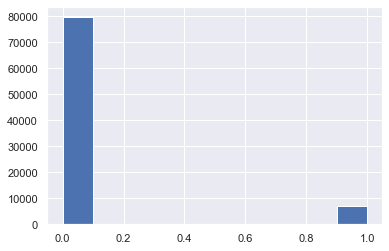

In [215]:
xgbraw_output['prediction(adopter)'].hist()

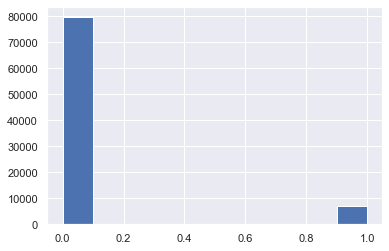

In [216]:
xgbcor_output['prediction(adopter)'].hist()

In [217]:
xgbraw_output.to_csv('xgbraw_output.csv', index=False)

In [218]:
xgbcor_output.to_csv('xgbcor_output.csv', index=False)